In [1]:
from typing import Union

from collections import defaultdict
from itertools import combinations

import numpy as np
from matplotlib import pyplot as plt
import cv2
from skimage.transform import rescale
from skimage.measure import label, find_contours
from skimage.filters import gaussian
from scipy.spatial.distance import cdist
import scipy.stats as st
import os
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

from ipywidgets import IntSlider, interact
from scipy.ndimage import convolve


COLORS = ('blue', 'green', 'black', 'yellow', 'red')
TRAIN_CASES = {i: fname for i, fname in enumerate(('all', 'black_blue_green', 'black_red_yellow',
                                                   'red_green_blue_inaccurate', 'red_green_blue'))}


def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6), dpi=350)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def get_gk(size=17, nsig=3):
    """Returns a 2D Gaussian kernel"""

    x = np.linspace(-nsig, nsig, size + 1)
    kernel_1d = np.diff(st.norm.cdf(x))
    
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    kernel_2d_norm = kernel_2d / kernel_2d.sum()
    
    return kernel_2d_norm


COLORS = ('blue', 'green', 'black', 'yellow', 'red')
TRAINS2SCORE = {1: 1, 2: 2, 3: 4, 4: 7, 6: 15, 8: 21}

In [2]:
images = {}
HLS_img = {}
HSV_img = {}
ycc = {}
folder = 'train'
for filename in os.listdir(folder):
    if ''.join(filename[-3:]) == 'jpg':
        images[filename] = cv2.imread(os.path.join(folder,filename))
        HLS_img[filename] = cv2.cvtColor(images[filename], cv2.COLOR_BGR2HLS)
        HSV_img[filename] = cv2.cvtColor(images[filename], cv2.COLOR_BGR2HSV)
        ycc[filename] = cv2.cvtColor(images[filename], cv2.COLOR_BGR2YCrCb)
        images[filename] = cv2.cvtColor(images[filename], cv2.COLOR_BGR2RGB)
        

In [ ]:
x = [[157, 2151], [227, 648], [236, 3200], [260, 2584], [436, 1778], [587, 2287], [672, 3551], [745, 2866], [760, 3242], [766, 887], [781, 1233], [812, 1524], [836, 2460], [866, 1878], [948, 1151], [1024, 3009], [1063, 1469], [1090, 848], [1190, 521], [1218, 3503], [1218, 1672], [1248, 1021], [1281, 2081], [1369, 2254], [1409, 3651], [1448, 1433], [1563, 1733], [1609, 2036], [1624, 2800], [1678, 3303], [1736, 3630], [1781, 1333], [1800, 787], [1821, 2339], [1851, 2578], [1887, 1760], [1981, 2066], [2075, 2987], [2096, 427], [2133, 827], [2181, 175], [2193, 3563], [2266, 2515], [2278, 3269], [2363, 2827], [2363, 1893], [2375, 420]]
len(x)

In [ ]:
img = images['all.jpg']
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.adaptiveThreshold(img_gray, 1,
                                  cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 27, 13)

hough_radii = np.arange(25, 30, 1)
hough_res = hough_circle(edges, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           min_xdistance=150, min_ydistance=150,
                                           total_num_peaks=47)

image2 = img.copy()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10), dpi=300)
for center_y, center_x, radius in zip(cy, cx, radii):
    for i in range(center_x - radius, center_x + radius):
        for j in range(center_y - radius, center_y + radius):
            image2[j, i] = (255, 255, 255)

ax.imshow(image2)
plt.show()

In [ ]:
mask_black_all = (HSV_img['all.jpg'][:, :, 2] < 30)
filter_bin = 1 - edges
kernel2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (22, 22))
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(11,11))
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(18,18))
mask_black_opened = cv2.morphologyEx(np.uint8(mask_black_all), cv2.MORPH_CLOSE, 
                           kernel1)

mask_black_opened = cv2.morphologyEx(mask_black_opened, cv2.MORPH_OPEN,
                           kernel=kernel2)
mask_black_opened = cv2.morphologyEx(mask_black_opened, cv2.MORPH_OPEN,
                           kernel=kernel3)
plot_img(mask_black_opened)

In [ ]:
kernel4 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
y = cv2.morphologyEx(mask_black_opened * filter_bin, cv2.MORPH_CLOSE, 
                           kernel4)

plot_img(y * filter_bin)

In [ ]:
plot_img(255 - mask_black_opened[..., None] * img)

y = 255 - mask_black_opened[..., None] * img
y[y == 255] = 0
plot_img(y)

In [ ]:
y_gray = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
edges = cv2.adaptiveThreshold(y, 1,
                                  cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 27, 13)

In [ ]:
sld1 = IntSlider(value=5, min=1, max=21, step=2, continuous_update=False)
sld2 = IntSlider(value=11, min=3, max=301, step=2, continuous_update=False)


def vary_thresh_parameters(kernel_size, C):
    y_gray = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
    edges = cv2.adaptiveThreshold(np.uint8(y_gray), 1,
                                  cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, kernel_size, C)
    plot_img(edges)

In [ ]:
interact(vary_thresh_parameters, kernel_size=sld1, C=sld2);

In [ ]:
plot_img(filter_bin)

In [ ]:
contours, hierarchy = cv2.findContours((mask_black_opened).astype('uint8') * filter_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
centers = []
img_cnt = images['all.jpg'].copy()
c = 0
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:
        #cv2.drawContours(img_cnt, [cnt], 0, (255,255,255), 10)
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers += [(cX, cY)]
        cv2.circle(img_cnt, (cX, cY), 7, (255, 255, 255), -1)
        c += 1
plt.figure(dpi=150)
plt.imshow(img_cnt, cmap='gray')
c

In [ ]:
centers

In [ ]:
(337 - 218) ** 2 + (2078 - 1917) ** 2

In [ ]:
sorted([(1, 2), (1,3), (2,3)])

In [ ]:
!ls

In [1]:
!python3 evaluate.py

{'green': 28, 'blue': 35, 'yellow': 26, 'red': 33, 'black': 22}
### train case `all` ###
Score = 7.28
Prediction time = 15.23s. Evaluation overhead = 0.12s.

{'green': 30, 'blue': 38, 'yellow': 2, 'red': 1, 'black': 31}
### train case `black_blue_green` ###
Score = 6.87
Prediction time = 15.92s. Evaluation overhead = 0.11s.

{'green': 0, 'blue': 0, 'yellow': 16, 'red': 28, 'black': 29}
### train case `black_red_yellow` ###
Score = 7.06
Prediction time = 16.09s. Evaluation overhead = 0.09s.

{'green': 34, 'blue': 38, 'yellow': 4, 'red': 40, 'black': 0}
### train case `red_green_blue_inaccurate` ###
Score = 7.74
Prediction time = 15.70s. Evaluation overhead = 0.11s.

{'green': 35, 'blue': 38, 'yellow': 2, 'red': 39, 'black': 0}
### train case `red_green_blue` ###
Score = 8.87
Prediction time = 16.37s. Evaluation overhead = 0.11s.

### Summary ###
Final train score = 37.82 out of 50.00
Total evaluation time = 79.87s for 5 images.
The platform limit is 2400s for 10 images.


In [ ]:
mask_red = (HSV_img['all.jpg'][:, :, 0] > 177) & (HSV_img['all.jpg'][:, :, 0] < 190)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (10, 10))
opening = cv2.morphologyEx(mask_red * filter_bin, cv2.MORPH_OPEN, kernel)

contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)

c = 0
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:
        c += 1

In [ ]:
plot_img(opening)

In [ ]:
img = images['black_blue_green.jpg']
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred_mask = cv2.GaussianBlur(img_gray, (7, 7), 0)
edges_for_masks = cv2.adaptiveThreshold(blurred_mask, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 27, 13)
filter_bin = 1 - edges_for_masks

ycc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
mask_blue = (60 < ycc[:, :, 2]) & ( ycc[:, :, 2] < 90)
contours, hierarchy = cv2.findContours(mask_blue * filter_bin, cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)

img_cnt = images['black_blue_green.jpg'].copy()
c = 0
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:
        cv2.drawContours(img_cnt, [cnt], 0, (255,255,255), 10)
        c += 1
plt.figure(dpi=150)
plt.imshow(img_cnt, cmap='gray')
c

In [ ]:
ycc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
mask_blue = (60 < ycc[:, :, 2]) & ( ycc[:, :, 2] < 90)
plot_img(mask_blue)

In [ ]:
ycc[...,2][990:1020,1220:1250]

In [ ]:
HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask_green = (HSV[:, :, 0] > 30) & (HSV[:, :, 0] < 70)
plot_img(mask_green)

In [ ]:
blurred_mask = cv2.GaussianBlur(img_gray, (7, 7), 0)
edges_for_masks = cv2.adaptiveThreshold(blurred_mask, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 27, 13)
filter_bin = 1 - edges_for_masks

plot_img(filter_bin)

blurred_new = cv2.GaussianBlur(filter_bin * img_gray, (5, 5), 0)
mask_new = cv2.adaptiveThreshold(blurred_new, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 23, 9)
filter_new = 1 - mask_new
plot_img(filter_new)

In [ ]:
img = images['all.jpg']
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges = cv2.adaptiveThreshold(img_gray, 255,
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 4)

hough_radii = np.arange(25, 40, 1)
hough_res = hough_circle(edges, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               min_xdistance=150, min_ydistance=150,
                                               total_num_peaks=47)
centers = list(zip(cy, cx))

blur = cv2.GaussianBlur(img_gray, (7, 7), 0)
edges_for_masks = cv2.adaptiveThreshold(blur, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 27, 13)
filter_bin = 1 - edges_for_masks
    #green
HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask_green = (HSV[:, :, 0] > 30) & (HSV[:, :, 0] < 70)
contours, hierarchy = cv2.findContours(mask_green * filter_bin, cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)

n_trains = {}
n_trains['green'] = 0
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:
        n_trains['green'] += 1

In [8]:
HSV[..., 0].max()

179

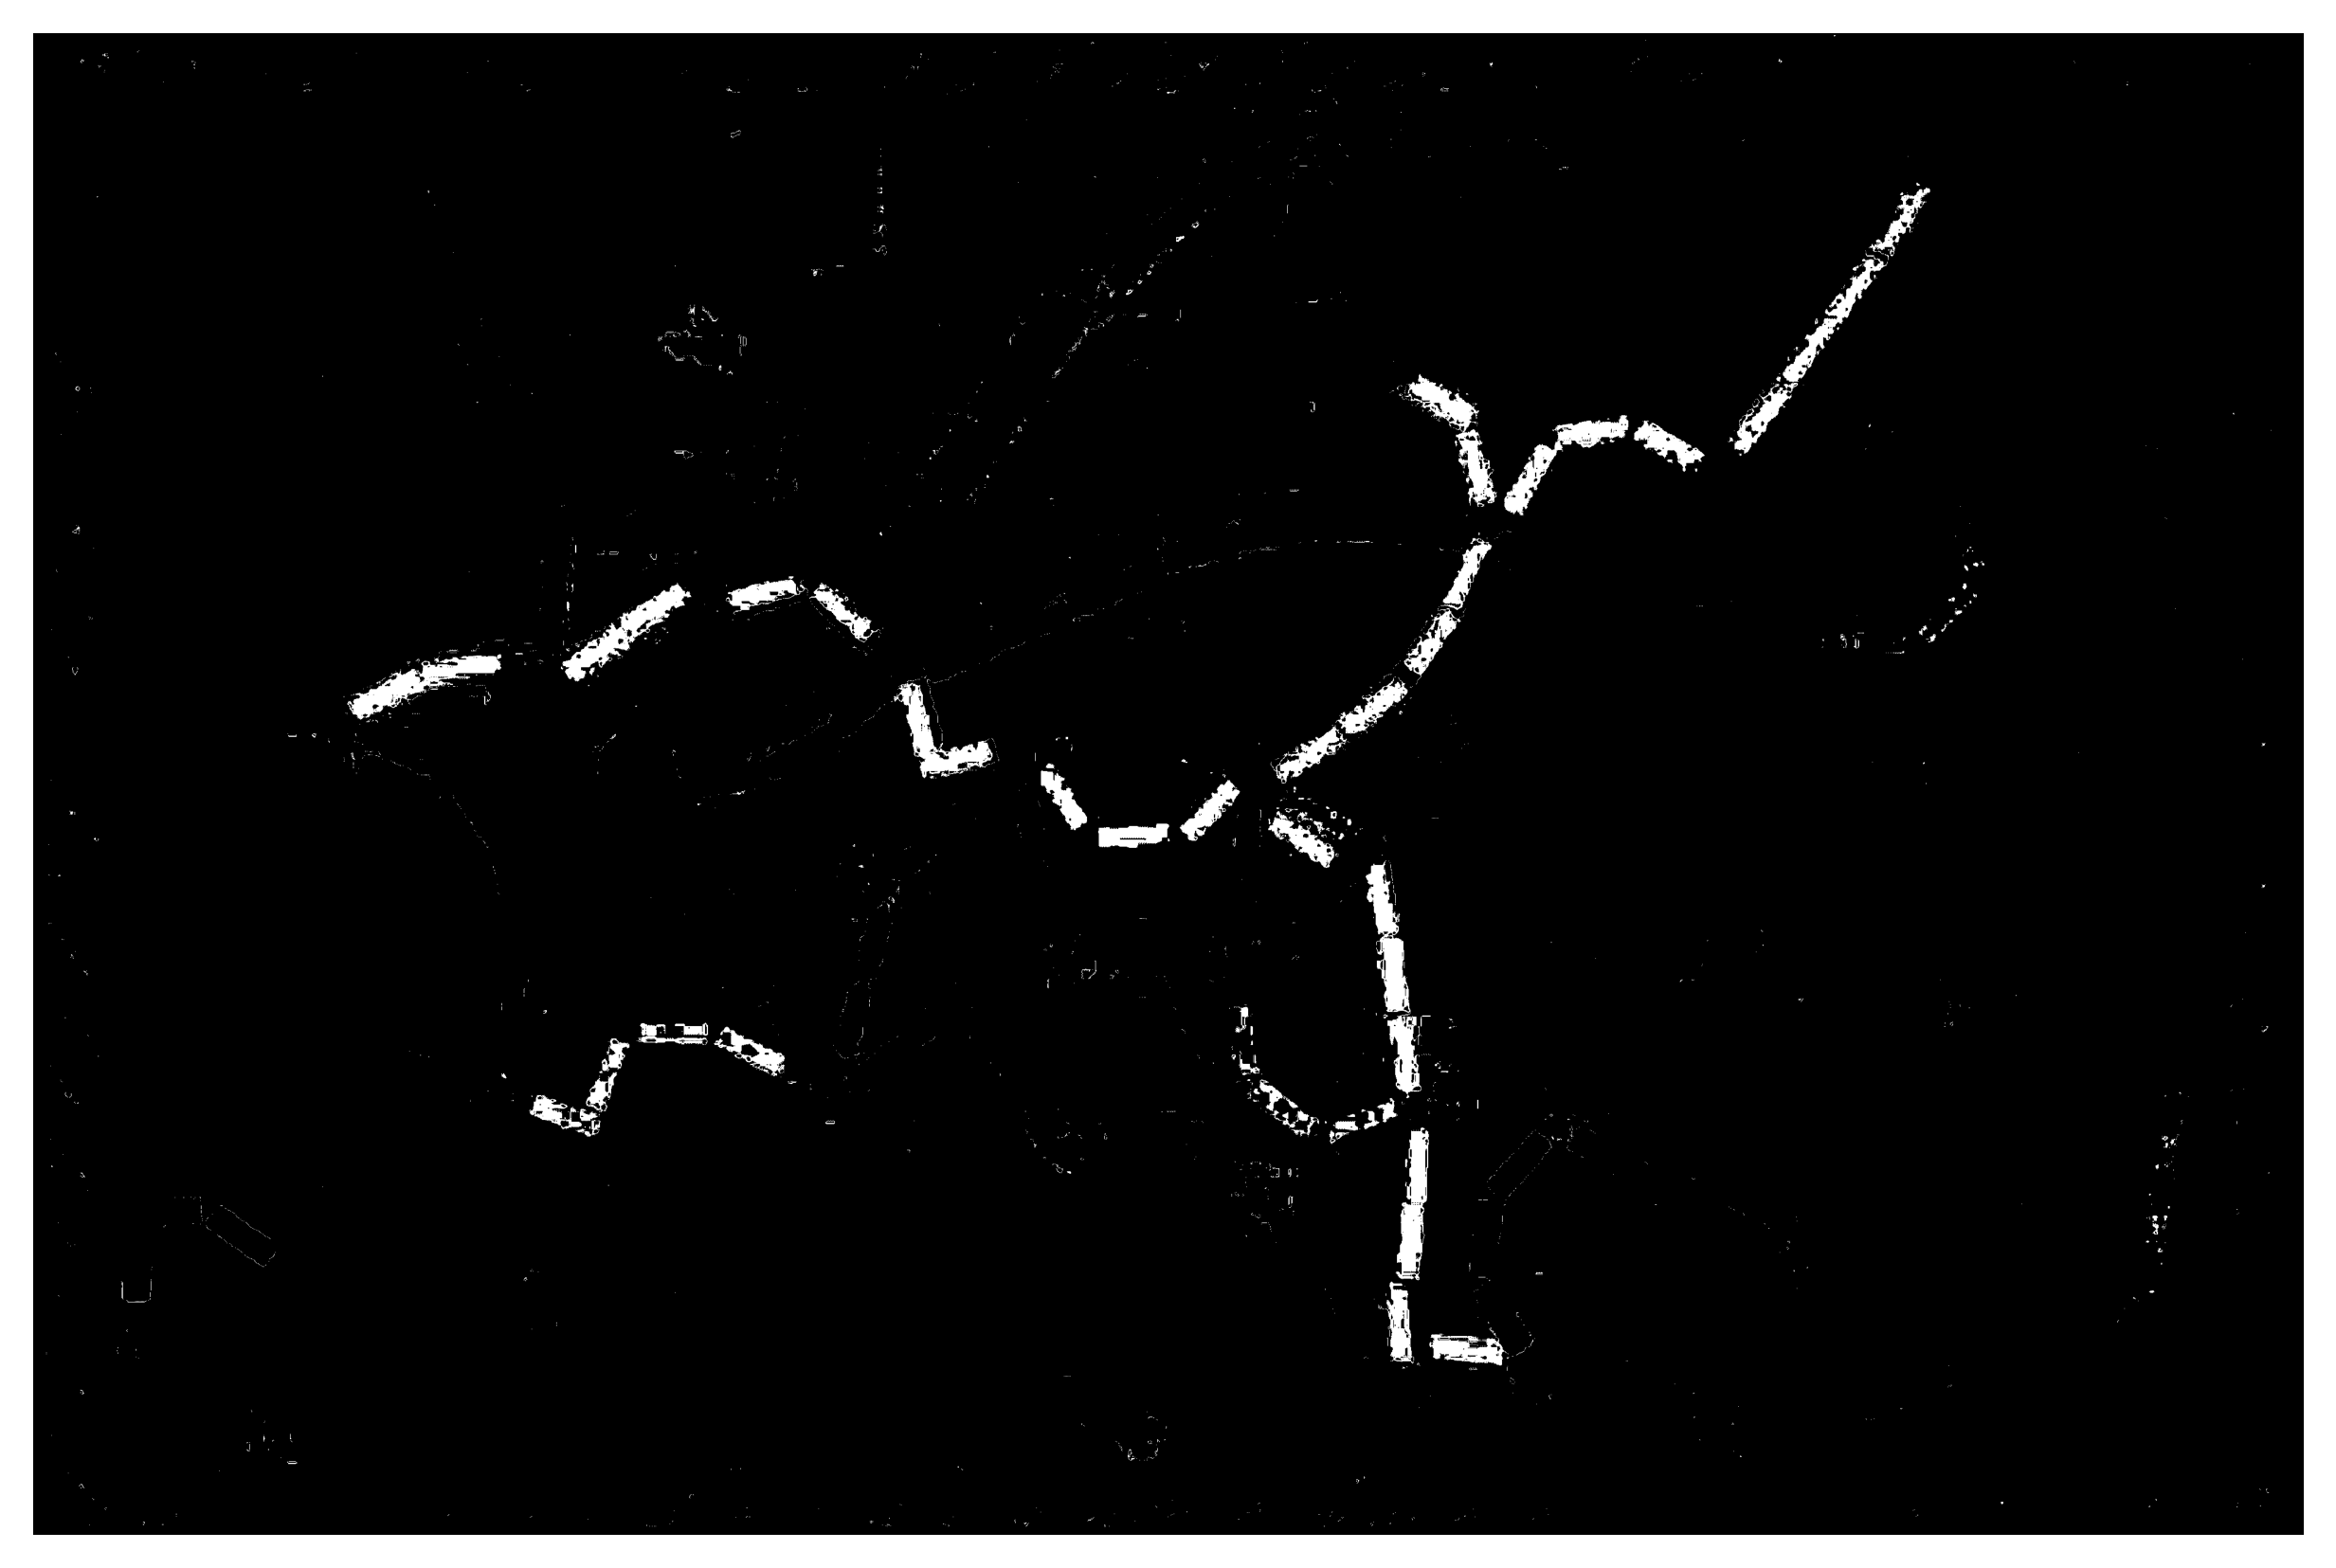

"contours, hierarchy = cv2.findContours(mask_green * filter_bin, cv2.RETR_TREE,\n                                           cv2.CHAIN_APPROX_SIMPLE)\n\nn_trains = {}\nprint('Green start:', n_trains)\nn_trains['green'] = 0\nfor cnt in contours:\n    if cv2.contourArea(cnt) > 1000:\n        n_trains['green'] += 1\nprint('Green end:', n_trains)"

In [28]:
img = images['all.jpg'].copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = cv2.adaptiveThreshold(img_gray, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 4)


blur = cv2.GaussianBlur(img_gray, (7, 7), 0)
edges_for_masks = cv2.adaptiveThreshold(blur, 1, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY_INV, 27, 13)
filter_bin = 1 - edges_for_masks
    #green
HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask_red = (HSV[:, :, 0] > 177) & (HSV[:, :, 0] < 190)
plot_img(mask_red)
'''contours, hierarchy = cv2.findContours(mask_green * filter_bin, cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)

n_trains = {}
print('Green start:', n_trains)
n_trains['green'] = 0
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:
        n_trains['green'] += 1
print('Green end:', n_trains)'''

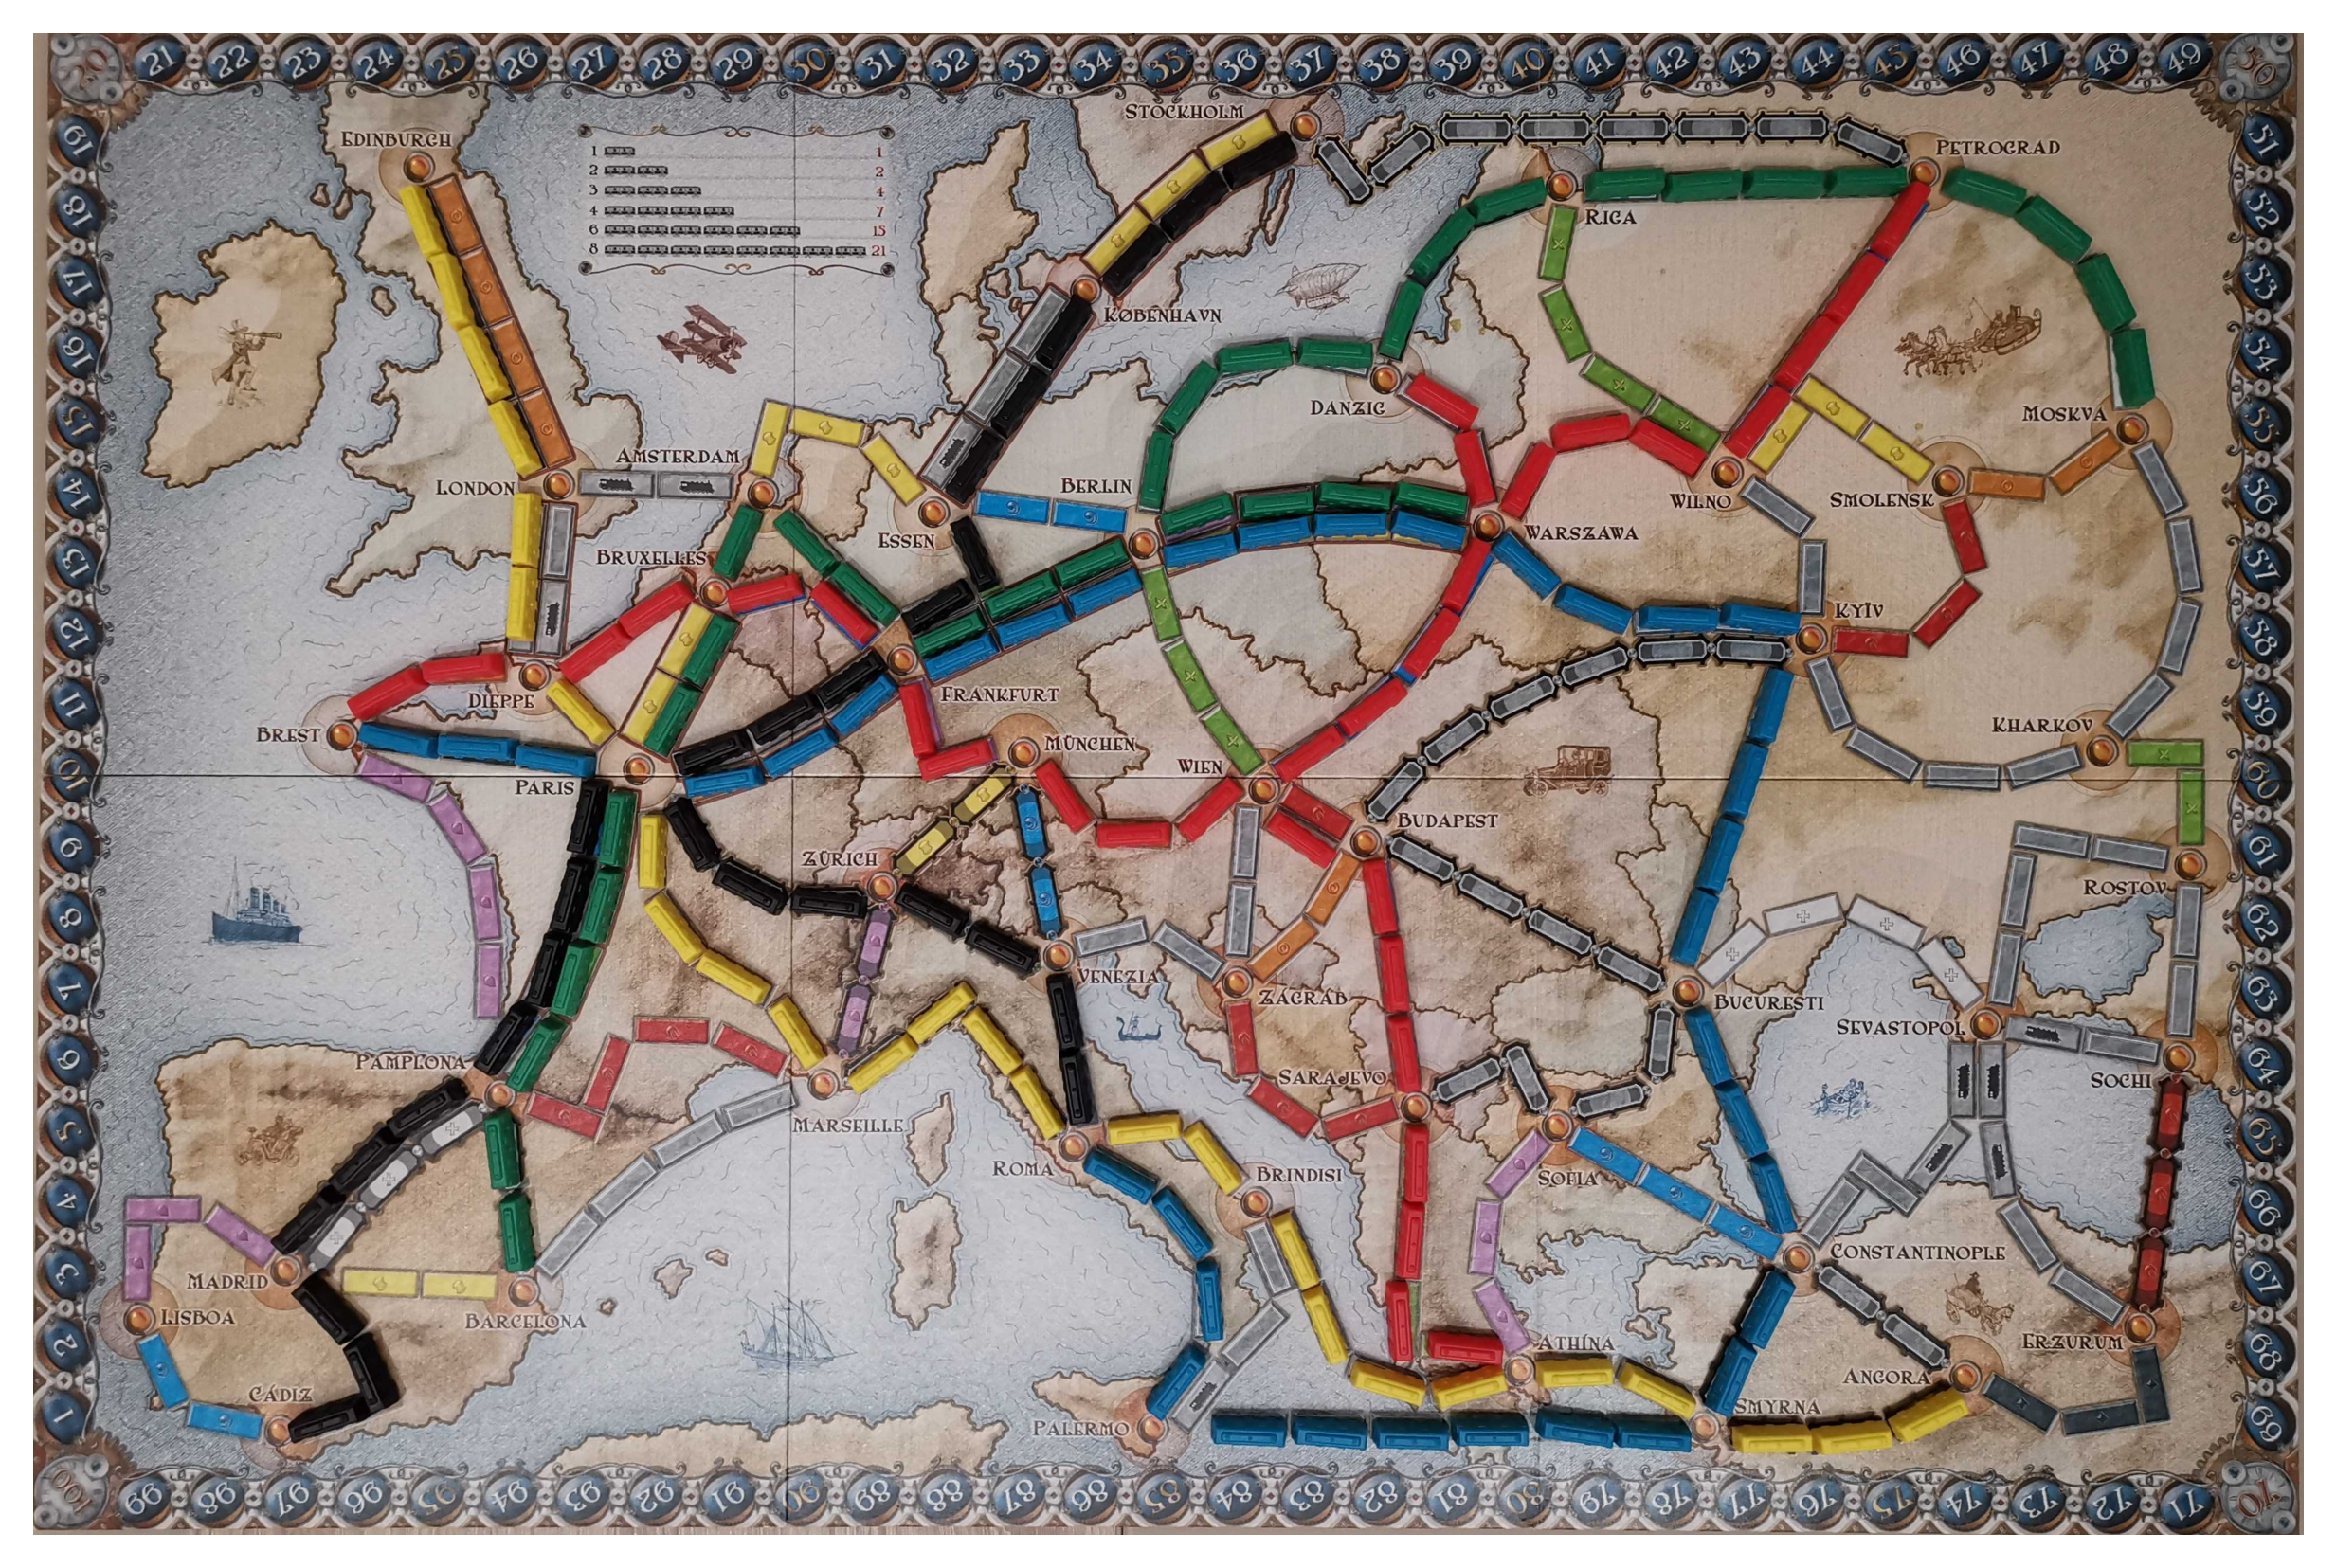

In [5]:
plot_img(img)

In [ ]:
from ticket_to_ride import predict_image

In [ ]:
predict_image(images['all.jpg'])

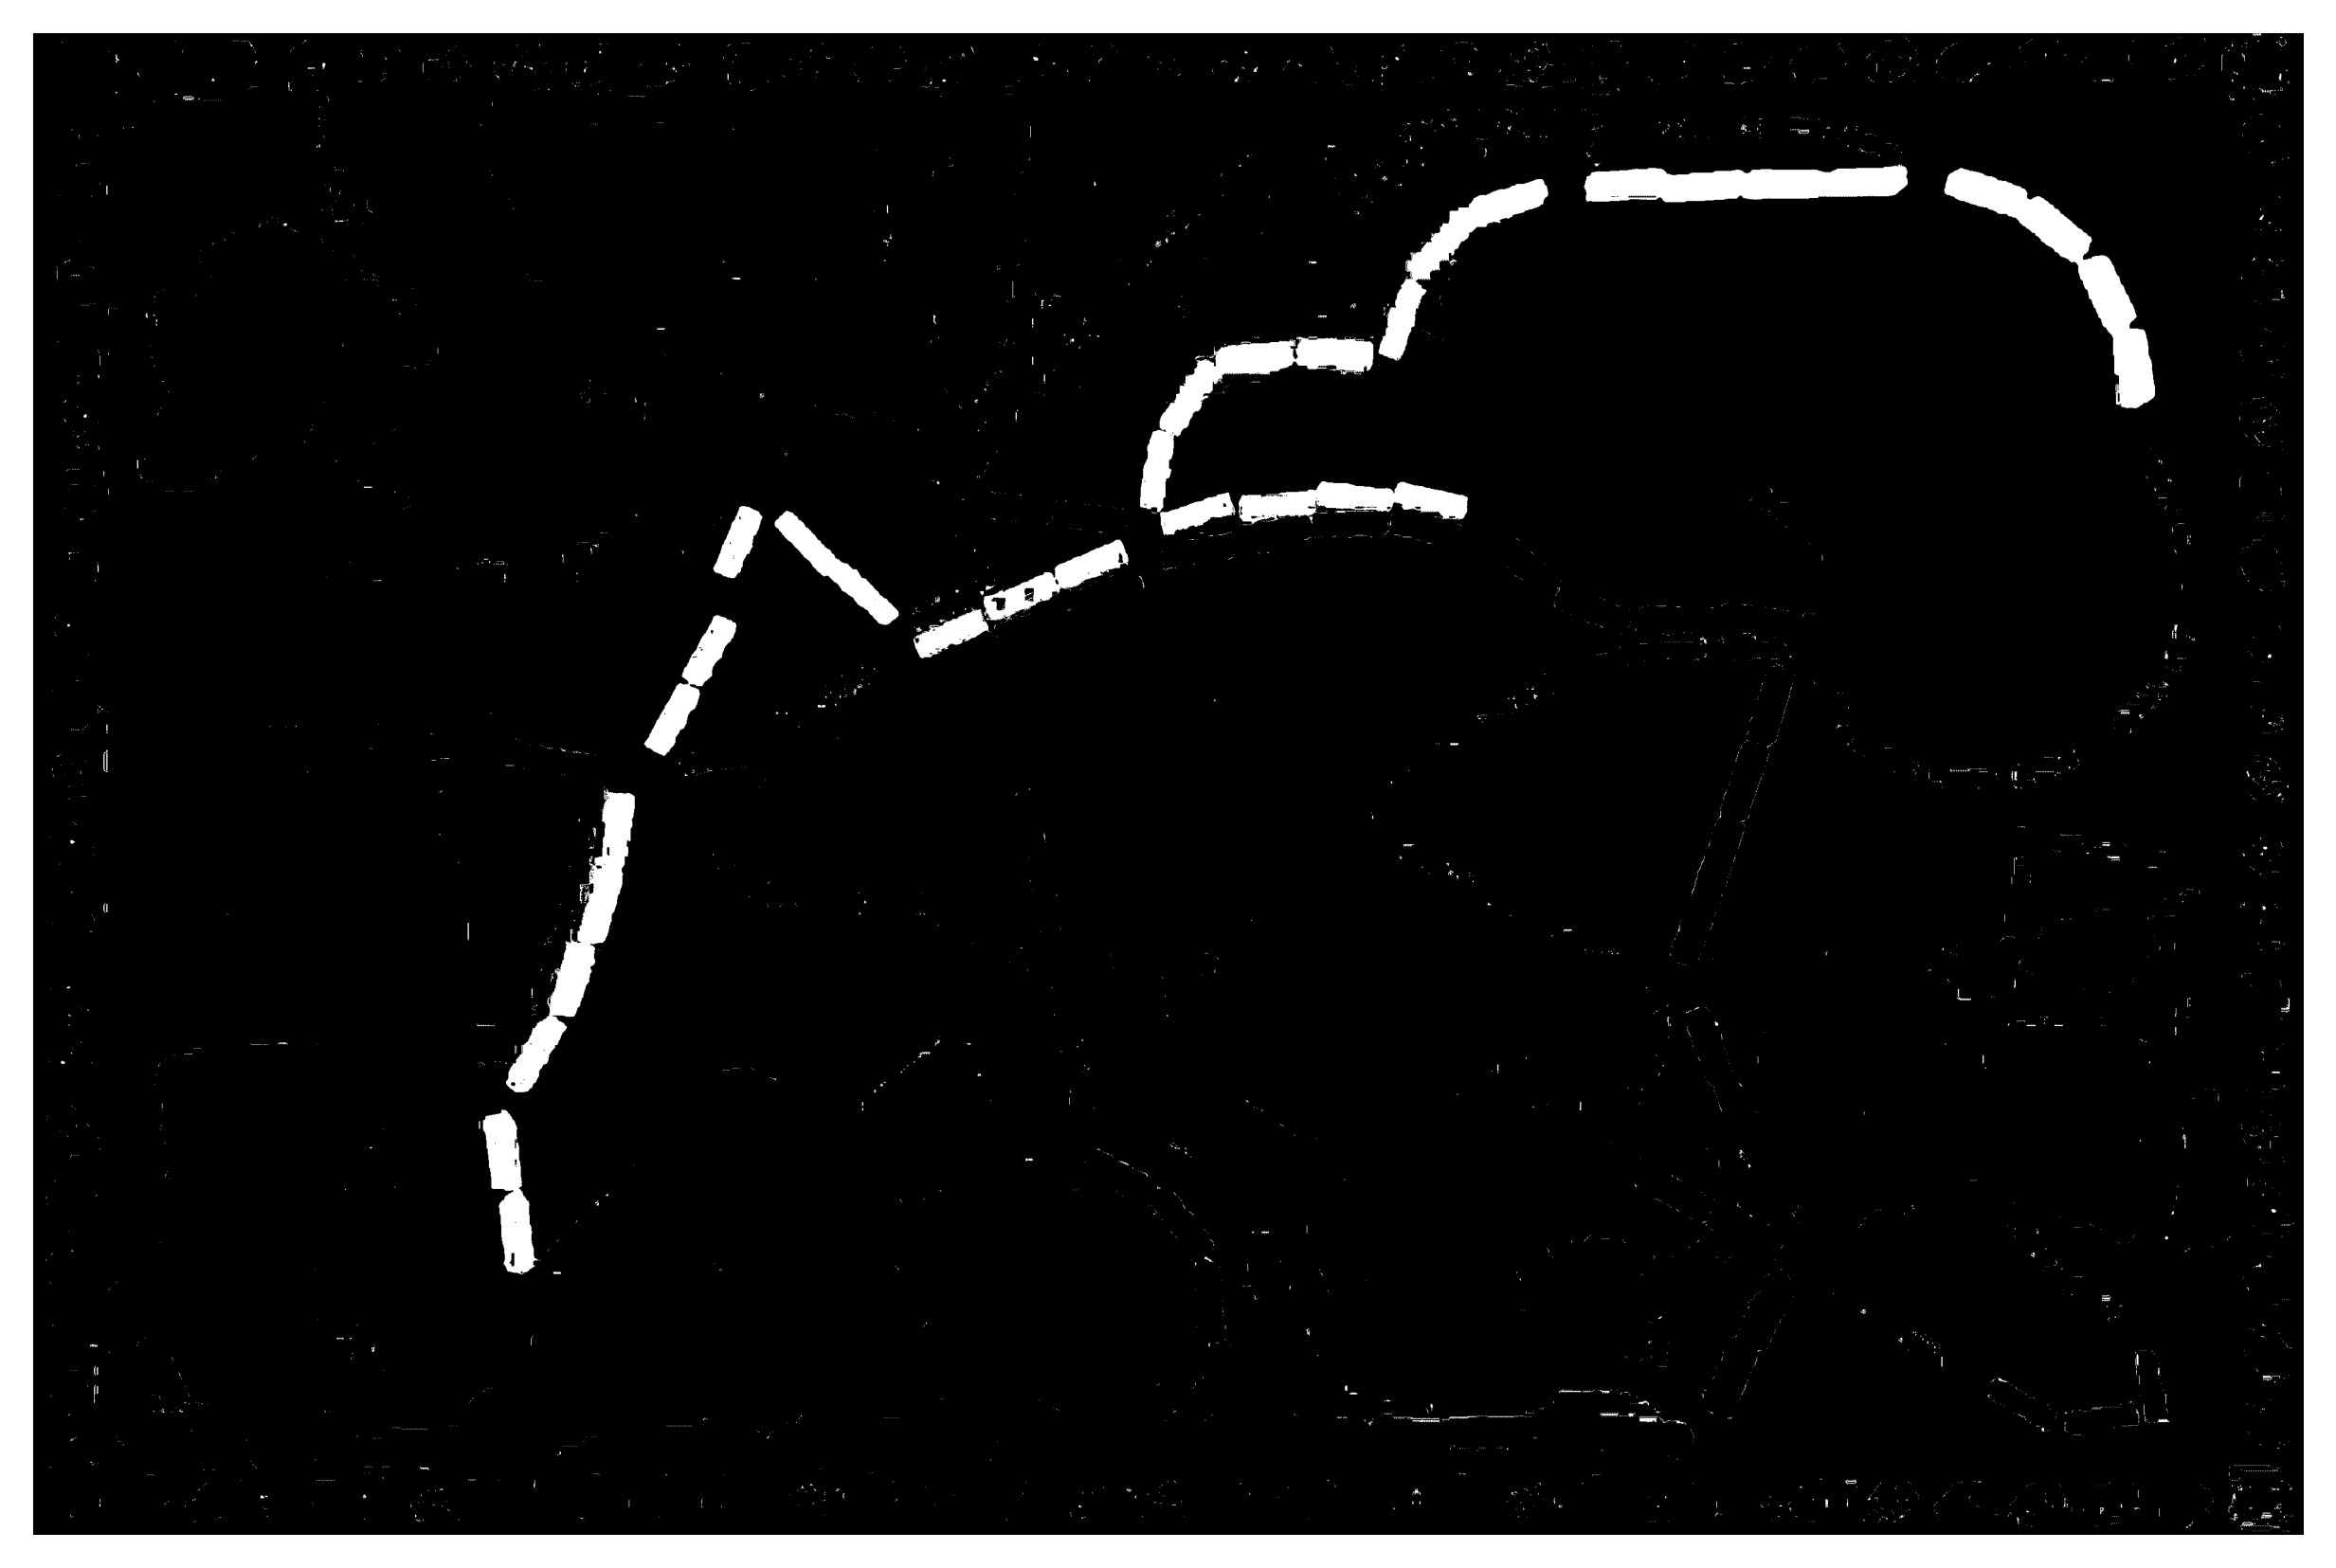

In [3]:
mask_green = (HSV_img['all.jpg'][:, :, 0] > 53) & (HSV_img['all.jpg'][:, :, 0] < 82)
plot_img(mask_green)

In [ ]:
plot_img(images['black_blue_green.jpg'])